In [1]:
#tensorいじりのテストを行う
import torch
import torch.nn
x = torch.randn(10,10,10)
print(torch.cuda.is_available())
from audio_to_multiple_pose_gan.dataset import generate_batch, get_processor
from audio_to_multiple_pose_gan.config import get_config
import warnings
warnings.simplefilter('ignore')

True


In [2]:
import pandas as pd
from common.consts import AUDIO_SHAPE
batch_size = 32
train_csv: str = "~/Desktop/AI-Experiments/speechandtext2gesture/Gestures/train.csv"
#train_csv: str = "~/AI-Experiments/speechandtext2gesture/Gestures/train.csv"
#df = pd.read_csv(self.args.train_csv)
#cfg = get_config(self.args.config)
df = pd.read_csv(train_csv)
#cfg = get_config(config)
cfg: dict = {"processor": "audio_to_pose", "input_shape": [None, AUDIO_SHAPE]}
process_row, decode_pose = get_processor(cfg)

In [3]:
from common.consts import AUDIO_SHAPE
configs = {
    "audio_to_pose": {"num_keypoints": 98, "processor": "audio_to_pose", "flatten": False, "input_shape": [None, AUDIO_SHAPE]},
    "audio_to_pose_inference": {"num_keypoints": 98, "processor": "audio_to_pose_inference", "flatten": False, "input_shape": [None, AUDIO_SHAPE]}
}
cfg: dict = {"processor": "audio_to_pose", "input_shape": [None, AUDIO_SHAPE]}
process_row, decode_pose = get_processor(cfg)

In [4]:
from audio_to_multiple_pose_gan.config import get_config
from audio_to_multiple_pose_gan.dataset import generate_batch, get_processor
#get_modelの実装は任せる
from audio_to_multiple_pose_gan.static_model_factory import Audio2PoseGANS, D_patchgan
from audio_to_multiple_pose_gan.static_model_factory import Audio2PoseGANSTransformer, Audio2PoseGANS_STTransformer
from audio_to_multiple_pose_gan.torch_layers import to_motion_delta, keypoints_to_train, keypoints_regloss
from common.audio_lib import save_audio_sample
from common.audio_repr import raw_repr
from common.consts import RIGHT_BODY_KEYPOINTS, LEFT_BODY_KEYPOINTS, LEFT_HAND_KEYPOINTS, \
    RIGHT_HAND_KEYPOINTS, POSE_SAMPLE_SHAPE, G_SCOPE, D_SCOPE, SR, FRAMES_PER_SAMPLE, AUDIO_SHAPE
from common.evaluation import compute_pck
from common.pose_logic_lib import translate_keypoints, get_sample_output_by_config
from common.pose_plot_lib import save_side_by_side_video, save_video_from_audio_video
from torch import optim
import torch
import pandas as pd
import argparse
from torch import nn

def get_training_keypoints():
    training_keypoints = []
    training_keypoints.extend(RIGHT_BODY_KEYPOINTS)
    training_keypoints.extend(LEFT_BODY_KEYPOINTS)
    for i in range(5):
        training_keypoints.extend(RIGHT_HAND_KEYPOINTS(i))
        training_keypoints.extend(LEFT_HAND_KEYPOINTS(i))
    training_keypoints = sorted(list(set(training_keypoints)))
    return training_keypoints

In [5]:
cfg: dict = {"processor": "audio_to_pose_new_keypoints", "input_shape": [None, AUDIO_SHAPE], "new_keypoints":True}
process_row, decode_pose = get_processor(cfg)
row = df.sample(n=1).iloc[0]

In [6]:
X, Y = process_row(row) #増えた次元の7, 8, 9がnose, eyesとなる。

In [7]:
import numpy as np
x = np.random.randn(64,2,49)

In [8]:
X, Y = generate_batch(df, process_row, batch_size)


In [9]:
decode_pose(Y[0], [0,0], speaker="shelly").shape

(64, 2, 52)

In [10]:
from common.audio_lib import raw_repr
audio, sr = raw_repr("response.wav",sr=16000)

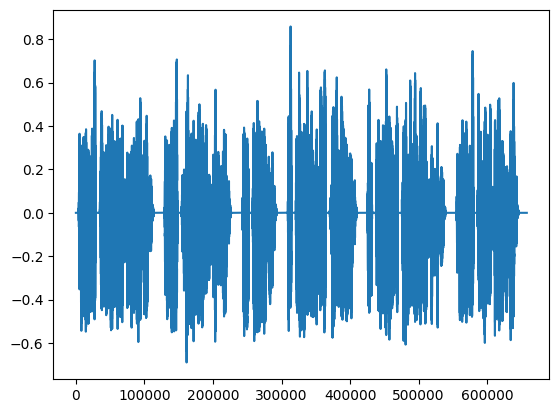

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(audio)
plt.show()

In [12]:
encoderlayer = nn.TransformerEncoderLayer(64, nhead=4, dim_feedforward=64 * 4, activation="gelu",batch_first=True, bias=False)
transformerencoder = nn.TransformerEncoder(encoderlayer, num_layers=2,)
decoderlayer = nn.TransformerDecoderLayer(64, nhead=4, dim_feedforward=64 * 4, activation="gelu",batch_first=True, bias=False)
transformerdecoder = nn.TransformerDecoder(encoderlayer, num_layers=2,)

In [13]:
Y.shape

(32, 64, 104)

In [14]:
Y.shape

(32, 64, 104)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
G_model = Audio2PoseGANS_STTransformer(1, 104).to(device)

In [22]:
X = torch.tensor(X).float().to(device)
Y = torch.tensor(Y).float().to(device)

In [21]:
G_model(X, Y).shape

torch.Size([32, 64, 104])

In [18]:
Y.shape

torch.Size([32, 64, 104])

In [19]:
X.shape

torch.Size([32, 67267])